In [374]:
import warnings
warnings.filterwarnings("ignore")
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [644]:
cm = 3
mN = 0.2
V2 = 1e-1    # used in reweighting the samples

mN_string = str(int(mN*1000))

In [645]:
df_eff = pd.read_csv("../data/eff_table.csv")
df_eff

,Type,Energy,Mass,Efficiency
0,s_M,3,200.0,0.261975
1,b_MuMu_lllqqv,3,NaN,0.261975
2,s_D,3,200.0,0.275995
3,b_MG5MuMu_lllqqv,3,NaN,0.145460


In [646]:
# extract the reconstruction eff from the eff table

eff_M = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN*1000) & (df_eff.Type=='s_M')]['Efficiency'].values[0]
eff_D = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN*1000) & (df_eff.Type=='s_D')]['Efficiency'].values[0]
# eff_baMu_qql = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_MuMu_lllqqv')]['Efficiency'].values[0]
eff_bMuMu_lllqqv = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b_MG5MuMu_lllqqv')]['Efficiency'].values[0]

In [647]:
eff_M = 0.425676
eff_D = 0.415283
eff_bMuMu_lllqqv = 0.33313

In [648]:
# store the muon collider luminosity, Xsec, for later estimating the yields

Lumi = 1000000

V2_sim = 2e-2

# corss section when |V|^2 = 1
Xsec_M = {3: {0.2: 5.31209813885e-05 / V2_sim}}    # first key: sqrt{s}, second key: m_N
Xsec_D = {3: {0.2: 5.54451933986e-05 / V2_sim}}
Xsec_bMuMu_lllqqv = {3: 0.00850002507732}   # key: sqrt{s}

Xsec_M

{3: {0.2: 0.0026560490694249998}}

In [649]:
# read the files, and calculate the corresponding yields

modes_dt = {
            1: {'mode': f'../data/features/sig_Maj_E-{cm}_m-{mN_string}_reco.root', 'yields': Lumi*Xsec_M[cm][mN]*eff_M*V2},
            2: {'mode': f'../data/features/sig_Dir_E-{cm}_m-{mN_string}_reco.root', 'yields': Lumi*Xsec_D[cm][mN]*eff_D*V2}, 
            3: {'mode': f'../data/features/bg_MG5MuMu_lllqqv_E-{cm}_reco.root', 'yields': Lumi*Xsec_bMuMu_lllqqv[cm]*eff_bMuMu_lllqqv},
           }

In [650]:
for k, v in modes_dt.items():
    print(f"{v['yields']:.2e}")
print()

b=0
for k, v in modes_dt.items():
    if (k < 3): continue
    b += v['yields']
    
print(f"{b:.2e}")

1.13e+02
1.15e+02
2.83e+03

2.83e+03


In [651]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
        print("reading: ", v['mode'])
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        df_i['target'] = k    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
#         print(k, v)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('\ntrain size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [652]:
tr_te_size = 1 
df_plot, _ = load_train_test(modes_dt, tr_te_size)


reading:  ../data/features/sig_Maj_E-3_m-200_reco.root
reading:  ../data/features/sig_Dir_E-3_m-200_reco.root
reading:  ../data/features/bg_MG5MuMu_lllqqv_E-3_reco.root

train size: 115620 (100.00%); test size: 0 (0.00%)
data points per mode:  [8582, 8616, 98422]


In [653]:
df_plot['etaDiffLeps'] = (df_plot['etaLep1'] - df_plot['etaLep2'])
df_plot['phiDiffLeps'] = abs(df_plot['phiLep1'] - df_plot['phiLep2'])
df_plot.loc[df_plot['phiDiffLeps'] > np.pi, 'phiDiffLeps'] = 2*np.pi - df_plot.loc[df_plot['phiDiffLeps'] > np.pi, 'phiDiffLeps']
df_plot['DeltaRLeps'] = ((df_plot['phiDiffLeps'])**2 + (df_plot['etaDiffLeps'])**2)**0.5

In [654]:
df_plot['etaDiffLepJJTrue'] = (df_plot['etaLepTrue'] - df_plot['etaJJTrue'])
df_plot['phiDiffLepJJTrue'] = abs(df_plot['phiLepTrue'] - df_plot['phiJJTrue'])
df_plot.loc[df_plot['phiDiffLepJJTrue'] > np.pi, 'phiDiffLepJJTrue'] = 2*np.pi - df_plot.loc[df_plot['phiDiffLepJJTrue'] > np.pi, 'phiDiffLepJJTrue']
df_plot['DeltaRLepJJTrue'] = ((df_plot['phiDiffLepJJTrue'])**2 + (df_plot['etaDiffLepJJTrue'])**2)**0.5

In [655]:
df_plot['etaDiffLep1JJ'] = (df_plot['etaLep1'] - df_plot['etaJJ'])
df_plot['phiDiffLep1JJ'] = abs(df_plot['phiLep1'] - df_plot['phiJJ'])
df_plot.loc[df_plot['phiDiffLep1JJ'] > np.pi, 'phiDiffLep1JJ'] = 2*np.pi - df_plot.loc[df_plot['phiDiffLep1JJ'] > np.pi, 'phiDiffLep1JJ']
df_plot['DeltaRLep1JJ'] = ((df_plot['phiDiffLep1JJ'])**2 + (df_plot['etaDiffLep1JJ'])**2)**0.5

In [656]:
df_plot['etaDiffLep2JJ'] = (df_plot['etaLep2'] - df_plot['etaJJ'])
df_plot['phiDiffLep2JJ'] = abs(df_plot['phiLep2'] - df_plot['phiJJ'])
df_plot.loc[df_plot['phiDiffLep2JJ'] > np.pi, 'phiDiffLep2JJ'] = 2*np.pi - df_plot.loc[df_plot['phiDiffLep2JJ'] > np.pi, 'phiDiffLep2JJ']
df_plot['DeltaRLep2JJ'] = ((df_plot['phiDiffLep2JJ'])**2 + (df_plot['etaDiffLep2JJ'])**2)**0.5

In [664]:
df_maj = df_plot[df_plot.target==1]
df_dir = df_plot[df_plot.target==2]
df_bkg = df_plot[df_plot.target==3]

### Investigate the pre-selection cut flow

0.9933581915637381 0.9926880222841226 0.9889455609518197
0.9933581915637381 0.9926880222841226 0.9889455609518197


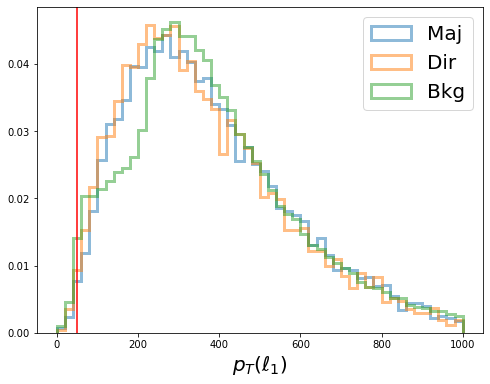

In [665]:

f = plt.figure(figsize=(8,6))
range_ = [0,1000]
bins_ = 50

plt.hist(df_maj['ptLep1'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['ptLep1'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['ptLep1'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');

ptLepCut = 50
plt.axvline(ptLepCut, color='red')
plt.xlabel(r"$p_T(\ell_1)$", fontsize=20)
plt.legend(fontsize=20)

df_maj_ = df_maj.copy()
df_dir_ = df_dir.copy()
df_bkg_ = df_bkg.copy()

df_maj = df_maj[df_maj['ptLep1']>ptLepCut]
df_dir = df_dir[df_dir['ptLep1']>ptLepCut]
df_bkg = df_bkg[df_bkg['ptLep1']>ptLepCut]

print(len(df_maj)/len(df_maj_), len(df_dir)/len(df_dir_), len(df_bkg)/len(df_bkg_))

print(len(df_maj)/len(df_plot[df_plot.target==1]), len(df_dir)/len(df_plot[df_plot.target==2]), len(df_bkg)/len(df_plot[df_plot.target==3]))

0.8124340175953079 0.7824155267157722 0.6943719563564633
0.8070379864833372 0.77669452181987 0.6866960638881551


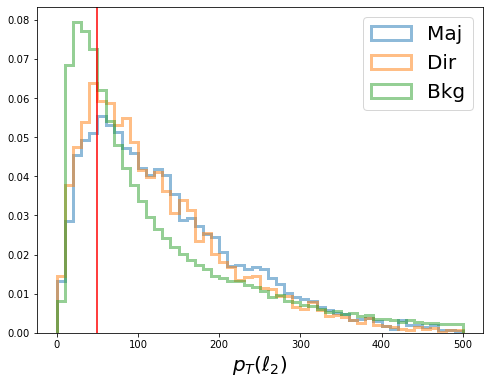

In [666]:

f = plt.figure(figsize=(8,6))
range_ = [0,500]
bins_ = 50

plt.hist(df_maj['ptLep2'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['ptLep2'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['ptLep2'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');

ptLepCut = 50
plt.axvline(ptLepCut, color='red')
plt.xlabel(r"$p_T(\ell_2)$", fontsize=20)
plt.legend(fontsize=20)

df_maj_ = df_maj.copy()
df_dir_ = df_dir.copy()
df_bkg_ = df_bkg.copy()

df_maj = df_maj[df_maj['ptLep2']>ptLepCut]
df_dir = df_dir[df_dir['ptLep2']>ptLepCut]
df_bkg = df_bkg[df_bkg['ptLep2']>ptLepCut]

print(len(df_maj)/len(df_maj_), len(df_dir)/len(df_dir_), len(df_bkg)/len(df_bkg_))

print(len(df_maj)/len(df_plot[df_plot.target==1]), len(df_dir)/len(df_plot[df_plot.target==2]), len(df_bkg)/len(df_plot[df_plot.target==3]))

0.5132832803927231 0.5511057979677226 0.4180599532447548
0.41423910510370543 0.42804085422469823 0.2870801243624393


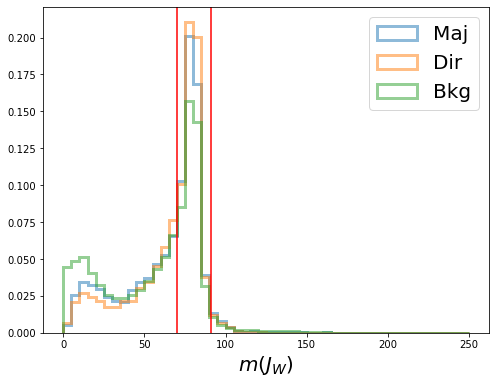

In [667]:

f = plt.figure(figsize=(8,6))
range_ = [0,250]
bins_ = 50

plt.hist(df_maj['mJJ'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['mJJ'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['mJJ'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');


# 70.0479 <= m(jj) <= 90.7481

mJJCut = 70.0479
plt.axvline(mJJCut, color='red')
plt.xlabel(r"$m(J_W)$", fontsize=20)
plt.legend(fontsize=20)


df_maj_ = df_maj.copy()
df_dir_ = df_dir.copy()
df_bkg_ = df_bkg.copy()

df_maj = df_maj[df_maj['mJJ']>mJJCut]
df_dir = df_dir[df_dir['mJJ']>mJJCut]
df_bkg = df_bkg[df_bkg['mJJ']>mJJCut]

mJJCut = 90.7481
plt.axvline(mJJCut, color='red')

df_maj = df_maj[df_maj['mJJ']<mJJCut]
df_dir = df_dir[df_dir['mJJ']<mJJCut]
df_bkg = df_bkg[df_bkg['mJJ']<mJJCut]

print(len(df_maj)/len(df_maj_), len(df_dir)/len(df_dir_), len(df_bkg)/len(df_bkg_))
print(len(df_maj)/len(df_plot[df_plot.target==1]), len(df_dir)/len(df_plot[df_plot.target==2]), len(df_bkg)/len(df_plot[df_plot.target==3]))

(0.9893108298171589, 0.9872559652928417, 0.9704831003362236)

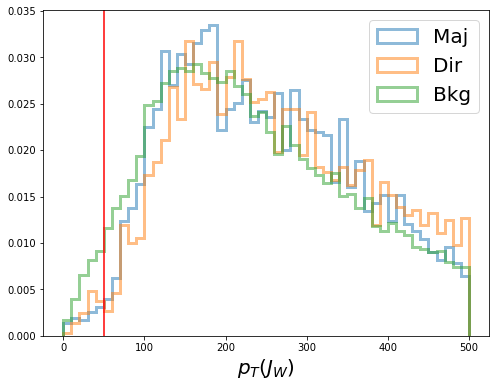

In [668]:

f = plt.figure(figsize=(8,6))
range_ = [0,500]
bins_ = 50

plt.hist(df_maj['ptJJ'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['ptJJ'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['ptJJ'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');


ptJJCut = 50
plt.axvline(ptJJCut, color='red')
plt.xlabel(r"$p_T(J_W)$", fontsize=20)
plt.legend(fontsize=20)

df_maj_ = df_maj.copy()
df_dir_ = df_dir.copy()
df_bkg_ = df_bkg.copy()

df_maj = df_maj[df_maj['ptJJ']>ptJJCut]
df_dir = df_dir[df_dir['ptJJ']>ptJJCut]
df_bkg = df_bkg[df_bkg['ptJJ']>ptJJCut]

len(df_maj)/len(df_maj_), \
len(df_dir)/len(df_dir_), \
len(df_bkg)/len(df_bkg_)

In [669]:

len(df_maj)/len(df_plot[df_plot.target==1]), \
len(df_dir)/len(df_plot[df_plot.target==2]), \
len(df_bkg)/len(df_plot[df_plot.target==3])

(0.40981123281286413, 0.42258588672237696, 0.27860640913616874)

### Investigating features for BDT

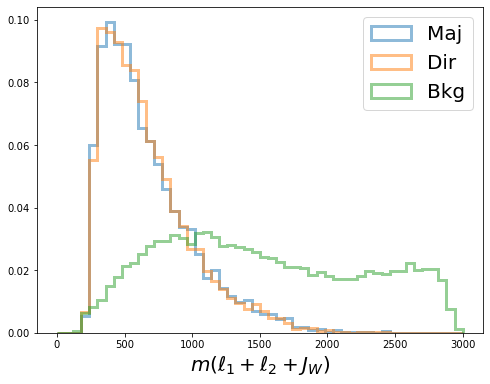

In [674]:

f = plt.figure(figsize=(8,6))
range_ = [0,3000]
bins_ = 50

plt.hist(df_maj['mJJLep1Lep2'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['mJJLep1Lep2'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['mJJLep1Lep2'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');
# plt.hist(df_bkg['mNLep'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');


# mNLepCut = 1500
# plt.axvline(mNLepCut, color='red')
plt.xlabel(r"$m(\ell_1+\ell_2+J_W)$", fontsize=20)
plt.legend(fontsize=20)

# df_maj_ = df_maj.copy()
# df_bkg_ = df_bkg.copy()

# df_maj = df_maj[df_maj['mNLep']<mNLepCut]
# df_bkg = df_bkg[df_bkg['mNLep']<mNLepCut]

# len(df_maj)/len(df_maj_), \
# len(df_bkg)/len(df_bkg_)

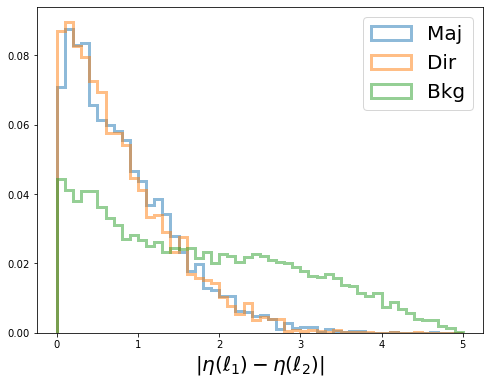

In [675]:

f = plt.figure(figsize=(8,6))
range_ = [0,5]
bins_ = 50

plt.hist(abs(df_maj['etaDiffLeps']), weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(abs(df_dir['etaDiffLeps']), weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(abs(df_bkg['etaDiffLeps']), weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');


plt.xlabel(r"$|\eta(\ell_1) - \eta(\ell_2)|$", fontsize=20)
plt.legend(fontsize=20)

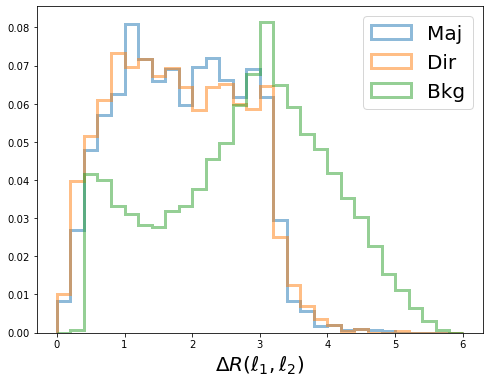

In [688]:

f = plt.figure(figsize=(8,6))
range_ = [0,6]
bins_ = 30

plt.hist(df_maj['DeltaRLeps'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['DeltaRLeps'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['DeltaRLeps'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');


plt.xlabel(r"$\Delta R(\ell_1, \ell_2)$", fontsize=20)
plt.legend(fontsize=20)

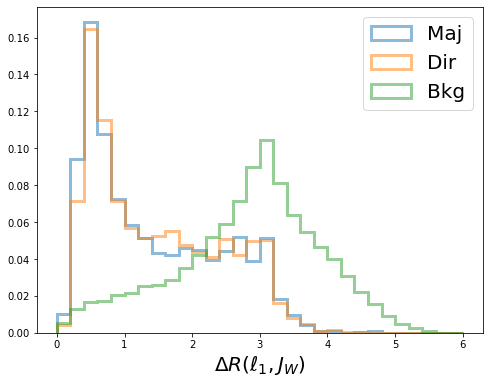

In [690]:


f = plt.figure(figsize=(8,6))
range_ = [0,6]
bins_ = 30

plt.hist(df_maj['DeltaRLep1JJ'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['DeltaRLep1JJ'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['DeltaRLep1JJ'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');


plt.xlabel(r"$\Delta R(\ell_1, J_W)$", fontsize=20)
plt.legend(fontsize=20)

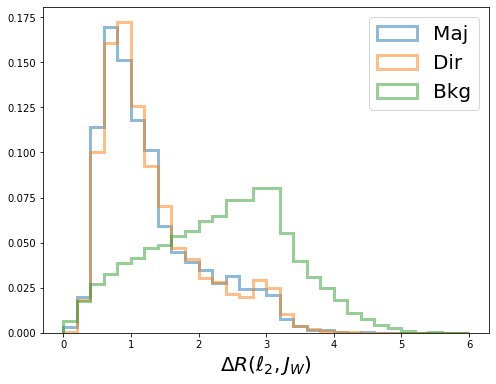

In [691]:


f = plt.figure(figsize=(8,6))
range_ = [0,6]
bins_ = 30

plt.hist(df_maj['DeltaRLep2JJ'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['DeltaRLep2JJ'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['DeltaRLep2JJ'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');


plt.xlabel(r"$\Delta R(\ell_2, J_W)$", fontsize=20)
plt.legend(fontsize=20)

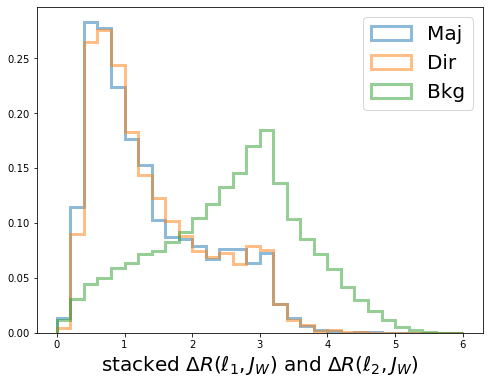

In [692]:
f = plt.figure(figsize=(8,6))
range_ = [0,6]
bins_ = 30

plt.hist(pd.concat([df_maj['DeltaRLep1JJ'], df_maj['DeltaRLep2JJ']]), weights=[1/len(df_maj)]*len(df_maj)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(pd.concat([df_dir['DeltaRLep1JJ'], df_dir['DeltaRLep2JJ']]), weights=[1/len(df_dir)]*len(df_dir)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(pd.concat([df_bkg['DeltaRLep1JJ'], df_bkg['DeltaRLep2JJ']]), weights=[1/len(df_bkg)]*len(df_bkg)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');

plt.xlabel(r"stacked $\Delta R(\ell_1, J_W)$ and $\Delta R(\ell_2, J_W)$", fontsize=20)
plt.legend(fontsize=20)

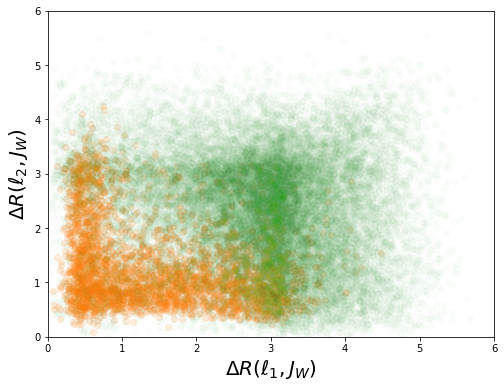

In [709]:
f = plt.figure(figsize=(8,6))

# plt.scatter(df_maj['DeltaRLep1JJ'], df_maj['DeltaRLep2JJ'], alpha=500/len(df_maj), color='C0')
plt.scatter(df_dir['DeltaRLep1JJ'], df_dir['DeltaRLep2JJ'], alpha=500/len(df_dir), color='C1')
plt.scatter(df_bkg['DeltaRLep1JJ'], df_bkg['DeltaRLep2JJ'], alpha=500/len(df_bkg), color='C2')
plt.xlim(0, 6);
plt.ylim(0, 6);

plt.xlabel(r"$\Delta R(\ell_1, J_W)$", fontsize=20);
plt.ylabel(r"$\Delta R(\ell_2, J_W)$", fontsize=20);

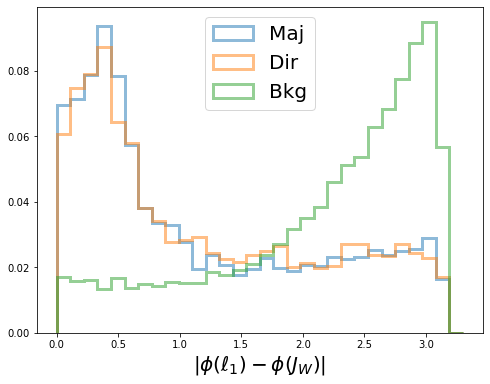

In [723]:


f = plt.figure(figsize=(8,6))
range_ = [0,3.3]
bins_ = 30

plt.hist(df_maj['phiDiffLep1JJ'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['phiDiffLep1JJ'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['phiDiffLep1JJ'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');


plt.xlabel(r"$|\phi(\ell_1) - \phi(J_W)|$", fontsize=20)
plt.legend(fontsize=20, loc=9)

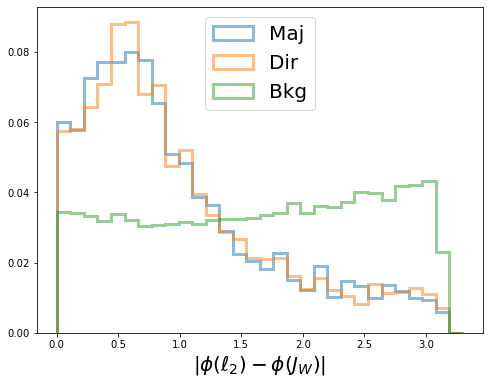

In [724]:


f = plt.figure(figsize=(8,6))
range_ = [0,3.3]
bins_ = 30

plt.hist(df_maj['phiDiffLep2JJ'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(df_dir['phiDiffLep2JJ'], weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(df_bkg['phiDiffLep2JJ'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');


plt.xlabel(r"$|\phi(\ell_2) - \phi(J_W)|$", fontsize=20)
plt.legend(fontsize=20, loc=9)

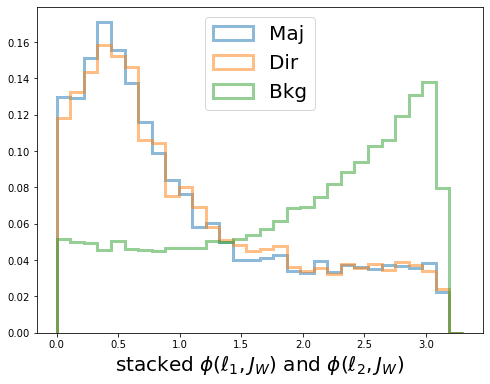

In [754]:
f = plt.figure(figsize=(8,6))
range_ = [0,3.3]
bins_ = 30

plt.hist(pd.concat([df_maj['phiDiffLep1JJ'], df_maj['phiDiffLep2JJ']]), weights=[1/len(df_maj)]*len(df_maj)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(pd.concat([df_dir['phiDiffLep1JJ'], df_dir['phiDiffLep2JJ']]), weights=[1/len(df_dir)]*len(df_dir)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(pd.concat([df_bkg['phiDiffLep1JJ'], df_bkg['phiDiffLep2JJ']]), weights=[1/len(df_bkg)]*len(df_bkg)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');

plt.xlabel(r"stacked $\phi(\ell_1, J_W)$ and $\phi(\ell_2, J_W)$", fontsize=20)
plt.legend(fontsize=20, loc=9)

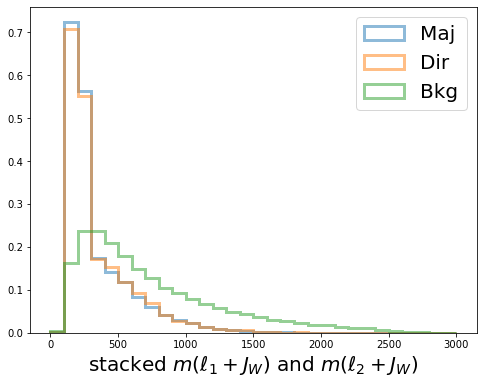

In [734]:
f = plt.figure(figsize=(8,6))
range_ = [0,3000]
bins_ = 30

plt.hist(pd.concat([df_maj['mN1'], df_maj['mN2']]), weights=[1/len(df_maj)]*len(df_maj)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Maj');
plt.hist(pd.concat([df_dir['mN1'], df_dir['mN2']]), weights=[1/len(df_dir)]*len(df_dir)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Dir');
plt.hist(pd.concat([df_bkg['mN1'], df_bkg['mN2']]), weights=[1/len(df_bkg)]*len(df_bkg)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='Bkg');

plt.xlabel(r"stacked $m(\ell_1+J_W)$ and $m(\ell_2+J_W)$", fontsize=20)
plt.legend(fontsize=20)

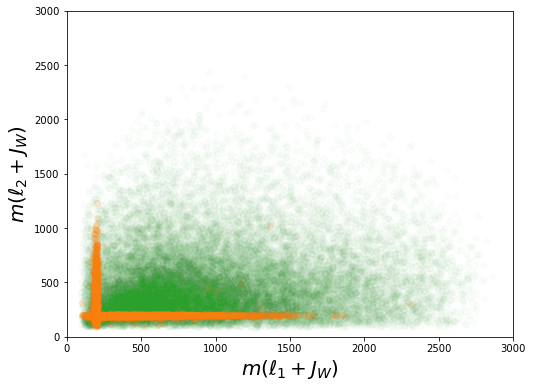

In [739]:
f = plt.figure(figsize=(8,6))

# plt.scatter(df_maj['mN1'], df_maj['mN2'], alpha=500/len(df_maj), color='C0')
plt.scatter(df_bkg['mN1'], df_bkg['mN2'], alpha=500/len(df_bkg), color='C2')
plt.scatter(df_dir['mN1'], df_dir['mN2'], alpha=500/len(df_dir), color='C1')
plt.xlim(0, 3000);
plt.ylim(0, 3000);

plt.xlabel(r"$m(\ell_1+J_W)$", fontsize=20);
plt.ylabel(r"$m(\ell_2+J_W)$", fontsize=20);

In [748]:
len(df_maj[df_maj['chargeLep1'] * df_maj['chargeLep2'] == 1])/len(df_maj)

0.47085584304805234

In [749]:
len(df_dir[df_dir['chargeLep1'] * df_dir['chargeLep2'] == 1])/len(df_dir)

0.0016478989288656962

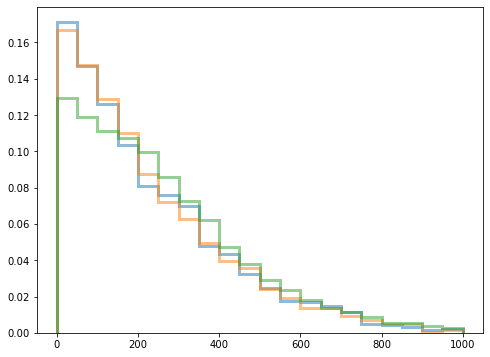

In [670]:

f = plt.figure(figsize=(8,6))
range_ = [0,1000]
bins_ = 20

plt.hist(abs(df_maj['ptLep1'] - df_maj['ptLep2']), weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_dir['ptLep1'] - df_dir['ptLep2']), weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_bkg['ptLep1'] - df_bkg['ptLep2']), weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

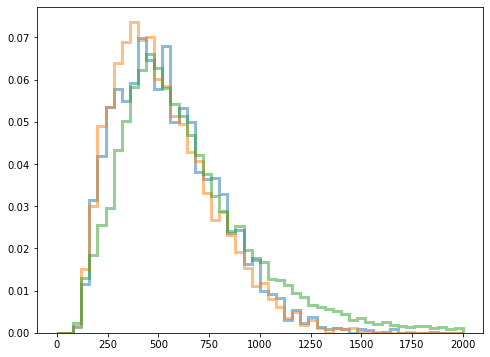

In [671]:

f = plt.figure(figsize=(8,6))
range_ = [0,2000]
bins_ = 50

plt.hist(abs(df_maj['ptLep1'] + df_maj['ptLep2']), weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_dir['ptLep1'] + df_dir['ptLep2']), weights=[1/len(df_dir)]*len(df_dir), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_bkg['ptLep1'] + df_bkg['ptLep2']), weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

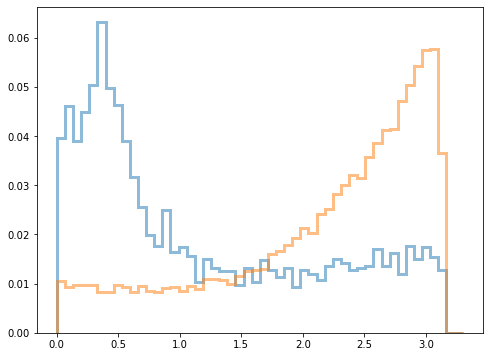

In [587]:

f = plt.figure(figsize=(8,6))
range_ = [0,3.3]
bins_ = 50

plt.hist(abs(df_maj['phiDiffLep1JJ']), weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_bkg['phiDiffLep1JJ']), weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

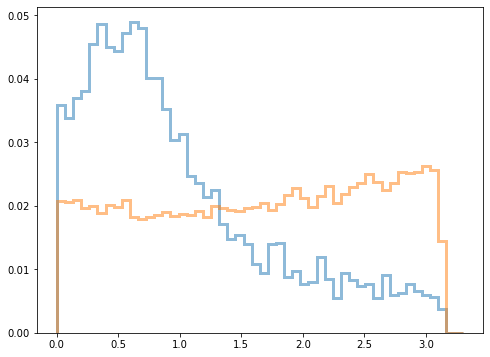

In [596]:

f = plt.figure(figsize=(8,6))
range_ = [0,3.3]
bins_ = 50

plt.hist(abs(df_maj['phiDiffLep2JJ']), weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_bkg['phiDiffLep2JJ']), weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

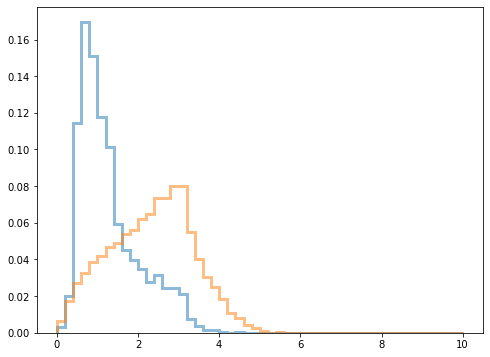

In [597]:

f = plt.figure(figsize=(8,6))
range_ = [0,10]
bins_ = 50

plt.hist(df_maj['DeltaRLep2JJ'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(df_bkg['DeltaRLep2JJ'], weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

Remaining: 0.7563264145578618


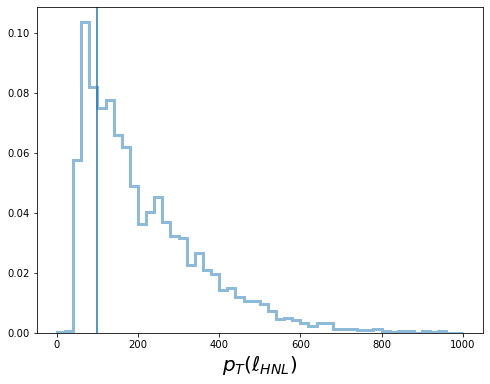

In [599]:

f = plt.figure(figsize=(8,6))
range_ = [0,1000]
bins_ = 50

plt.hist(df_maj['ptLepTrue'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

plt.axvline(100)
print("Remaining:", len(df_maj[df_maj.ptLepTrue > 100])/len(df_maj))

plt.xlabel(r"$p_T(\ell_{HNL})$", fontsize=20);

Remaining: 0.9488200170599943


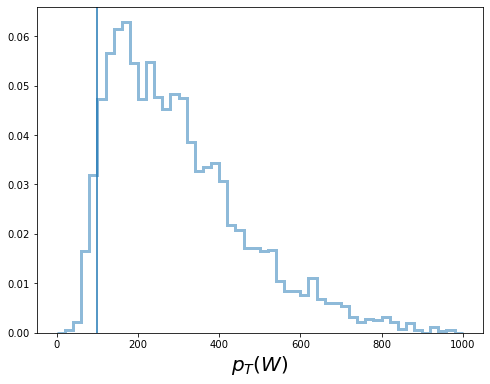

In [600]:

f = plt.figure(figsize=(8,6))
range_ = [0,1000]
bins_ = 50

plt.hist(df_maj['ptJJTrue'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

plt.axvline(100)
print("Remaining:", len(df_maj[df_maj.ptJJTrue > 100])/len(df_maj))


plt.xlabel(r"$p_T(W)$", fontsize=20);

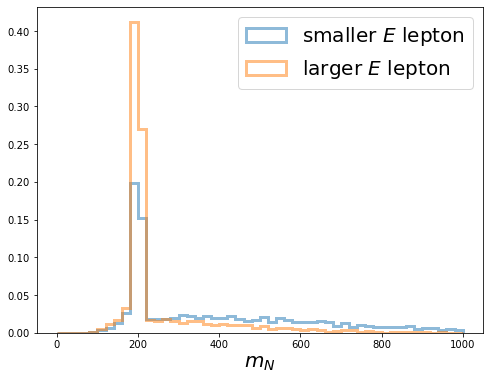

In [602]:

f = plt.figure(figsize=(8,6))
range_ = [0,1000]
bins_ = 50

plt.hist(df_maj['mN1'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='smaller $E$ lepton');
plt.hist(df_maj['mN2'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step', label='larger $E$ lepton');



plt.xlabel(r"$m_N$", fontsize=20);
plt.legend(fontsize=20);

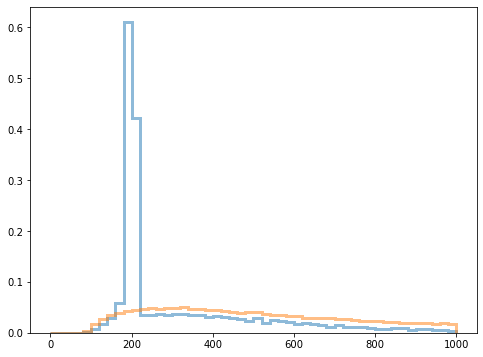

In [617]:

f = plt.figure(figsize=(8,6))
range_ = [0,1000]
bins_ = 50

plt.hist(pd.concat([df_maj['mN1'], df_maj['mN2']]), weights=[1/len(df_maj)]*len(df_maj)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(pd.concat([df_bkg['mN1'], df_bkg['mN2']]), weights=[1/len(df_bkg)]*len(df_bkg)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

# DeltaRLepJJCut = 2.5
# plt.axvline(DeltaRLepJJCut, color='red')
# df_maj_ = df_maj.copy()
# df_bkg_ = df_bkg.copy()

# df_maj = df_maj[df_maj['DeltaRLepJJ']<DeltaRLepJJCut]
# df_bkg = df_bkg[df_bkg['DeltaRLepJJ']<DeltaRLepJJCut]

# len(df_maj)/len(df_maj_), \
# len(df_bkg)/len(df_bkg_)

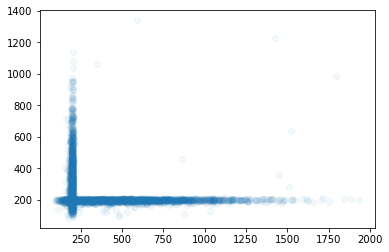

In [618]:
plt.scatter(df_maj['mN1'], df_maj['mN2'], alpha=0.05)

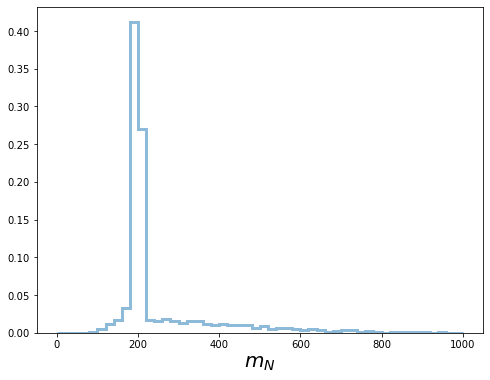

In [619]:

f = plt.figure(figsize=(8,6))
range_ = [0,1000]
bins_ = 50

plt.hist(df_maj['mN2'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');



plt.xlabel(r"$m_N$", fontsize=20);

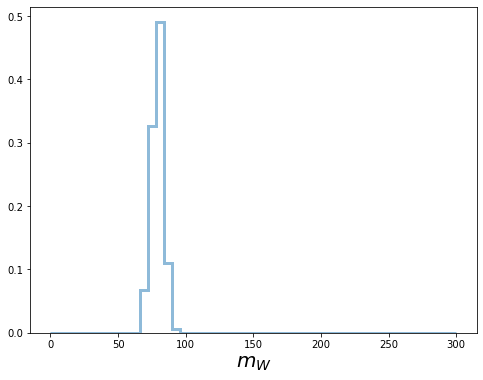

In [620]:

f = plt.figure(figsize=(8,6))
range_ = [0,300]
bins_ = 50

plt.hist(df_maj['mJJ'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');



plt.xlabel(r"$m_{W}$", fontsize=20);

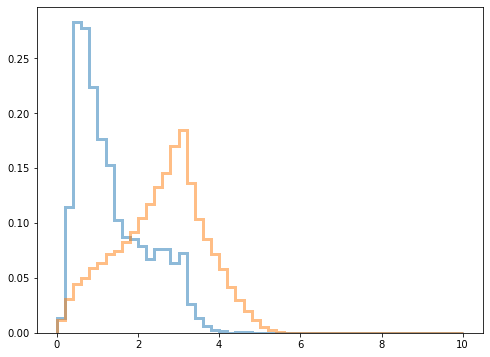

In [621]:

f = plt.figure(figsize=(8,6))
range_ = [0,10]
bins_ = 50

plt.hist(pd.concat([df_maj['DeltaRLep1JJ'], df_maj['DeltaRLep2JJ']]), weights=[1/len(df_maj)]*len(df_maj)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(pd.concat([df_bkg['DeltaRLep1JJ'], df_bkg['DeltaRLep2JJ']]), weights=[1/len(df_bkg)]*len(df_bkg)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

# DeltaRLepJJCut = 2.5
# plt.axvline(DeltaRLepJJCut, color='red')
# df_maj_ = df_maj.copy()
# df_bkg_ = df_bkg.copy()

# df_maj = df_maj[df_maj['DeltaRLepJJ']<DeltaRLepJJCut]
# df_bkg = df_bkg[df_bkg['DeltaRLepJJ']<DeltaRLepJJCut]

# len(df_maj)/len(df_maj_), \
# len(df_bkg)/len(df_bkg_)

(0.0, 6.0)

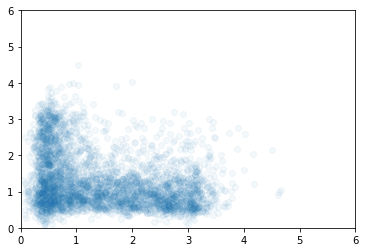

In [623]:
plt.scatter(df_maj['DeltaRLep1JJ'], df_maj['DeltaRLep2JJ'], alpha=0.05)
plt.xlim(0, 6)
plt.ylim(0, 6)

(0.0, 6.0)

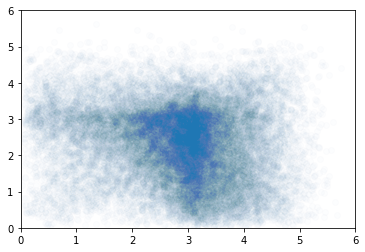

In [624]:

plt.scatter(df_bkg['DeltaRLep1JJ'], df_bkg['DeltaRLep2JJ'], alpha=0.01)
plt.xlim(0, 6)
plt.ylim(0, 6)

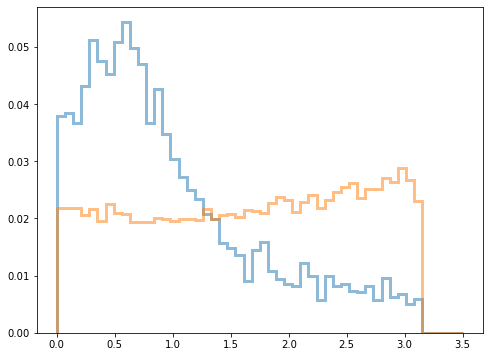

In [627]:

f = plt.figure(figsize=(8,6))
range_ = [0, 3.5]
bins_ = 50

plt.hist(abs(df_maj['phiDiffLep2JJ']), weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_bkg['phiDiffLep2JJ']), weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

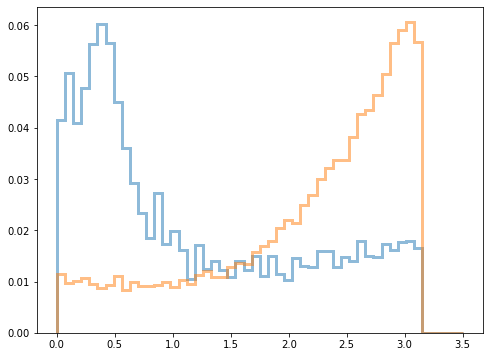

In [629]:

f = plt.figure(figsize=(8,6))
range_ = [0, 3.5]
bins_ = 50

plt.hist(abs(df_maj['phiDiffLep1JJ']), weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_bkg['phiDiffLep1JJ']), weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');

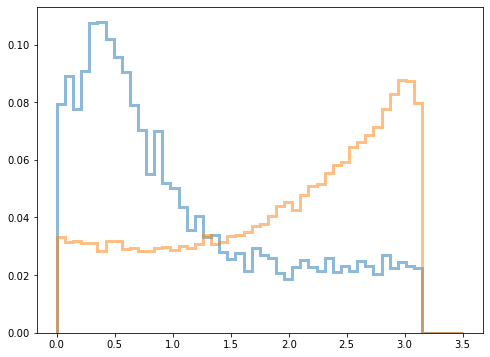

In [630]:

f = plt.figure(figsize=(8,6))
range_ = [0, 3.5]
bins_ = 50

plt.hist(abs(pd.concat([df_maj['phiDiffLep1JJ'], df_maj['phiDiffLep2JJ']])), weights=[1/len(df_maj)]*len(df_maj)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(pd.concat([df_bkg['phiDiffLep1JJ'], df_bkg['phiDiffLep2JJ']])), weights=[1/len(df_bkg)]*len(df_bkg)*2, range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');


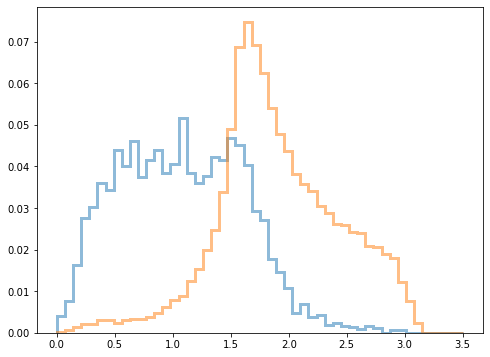

In [631]:

f = plt.figure(figsize=(8,6))
range_ = [0, 3.5]
bins_ = 50

plt.hist(abs(df_maj[['phiDiffLep1JJ', 'phiDiffLep2JJ']].mean(axis=1)), weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_bkg[['phiDiffLep1JJ', 'phiDiffLep2JJ']].mean(axis=1)), weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');


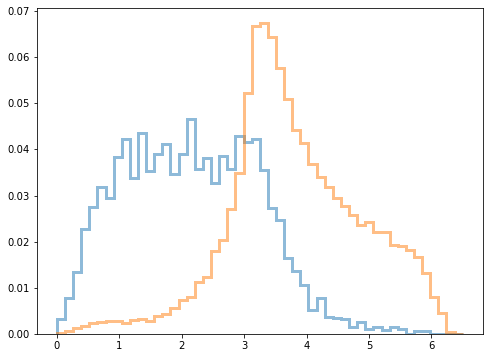

In [632]:

f = plt.figure(figsize=(8,6))
range_ = [0, 6.5]
bins_ = 50

plt.hist(abs(df_maj[['phiDiffLep1JJ', 'phiDiffLep2JJ']].sum(axis=1)), weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
plt.hist(abs(df_bkg[['phiDiffLep1JJ', 'phiDiffLep2JJ']].sum(axis=1)), weights=[1/len(df_bkg)]*len(df_bkg), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');


(0.0, 3.5)

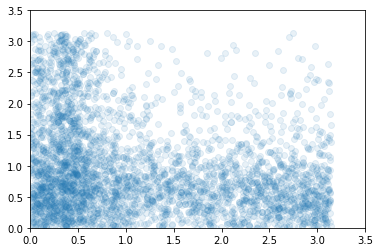

In [639]:

plt.scatter(df_maj['phiDiffLep1JJ'], df_maj['phiDiffLep2JJ'], alpha=0.1)
plt.xlim(0, 3.5)
plt.ylim(0, 3.5)

(0.0, 3.5)

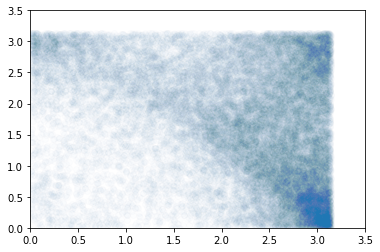

In [640]:

plt.scatter(df_bkg['phiDiffLep1JJ'], df_bkg['phiDiffLep2JJ'], alpha=0.01)
plt.xlim(0, 3.5)
plt.ylim(0, 3.5)

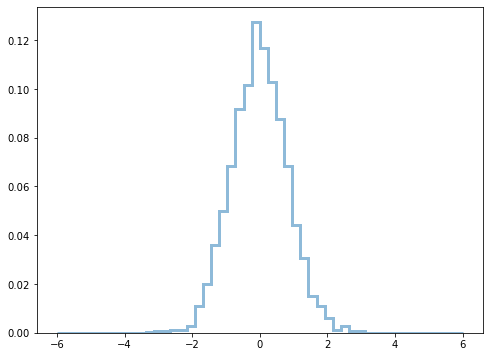

In [753]:

f = plt.figure(figsize=(8,6))
range_ = [-6, 6]
bins_ = 50

plt.hist(df_maj['etaNTrue'], weights=[1/len(df_maj)]*len(df_maj), range=range_, bins=bins_, alpha=0.5, lw=3, histtype='step');
